## Transfomer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image
plt.style.use('seaborn-white')

### Positional Encoding

- 기존의 RNN은 단어의 위치를 따라 순차적으로 입력받아 단어의 위치정보를 활용할 수 있었음.
- transfomer의 겨우, RNN을 활용하지 않았기 때문에 단어의 위치정보를 다른 방식으로 함.
- 이를 위해 각 단어의 embedding vector의 위치 정보들을 더하게 되는데 이를 positional encoding이라고 함.
- 보통 positional encoding은 sin, cos를 이용하여 계산

In [2]:
def positional_encoding(dim, sentence_length):
    encoded_vec = np.array([pos / np.power(10000, 2*i / dim) for pos in range(sentence_length) for i in range(dim)])
    ### pos = 전체 sentence에서 몇번 째 sentence인지
    encoded_vec[::2] = np.sin(encoded_vec[::2]) ## 짝수 
    encoded_vec[1::2] = np.cos(encoded_vec[1::2]) ## 홀수
    return tf.constant(encoded_vec.reshape([sentence_length, dim]), dtype = tf.float32)

### Layer Regularization (Add & Norm)

- 레이어 정규화에서는 텐서의 마지막 차원에 대해 평균과 분산을 구하고, 이 값을 통해 값을 정규화함
- 해당 정규화를 통해 각 층의 연결에 편리하게 적용하기 위해 sublayer_connection()을 선언

In [3]:
def layer_norm(inputs, eps=1e-6):
    feature_shape = inputs.get_shape()[-1:] # 열 
    mean = tf.keras.backend.meam(inputs, [-1], keepdims = True)
    std = tf.keras.backend.std(inputs, [-1], keepdims = True)
    beta = tf.Variable(tf.zero(feature_shape), trainable = False)
    gamma = tf.Variable(tf.ones(feature_shape), trainable = False)
    return gamma * (inputs - mean) / (std + eps) + beta ### std가 0일 때를 방지하기 위해 eps값을 더해줌 

In [4]:
def sublayer_connection(inputs, sublayer, dropout = 0.2):
    outputs = layer_norm(inputs + tf.keras.layers.Dropout(dropout)(sublayer))
    return outputs

- sublayer_connection를 통해 layer를 연결
- 정규화 진행
- dropout 진행

### Attention

- multi-head attention과 self-attention을 사용

#### multi-head attention
- 디코더가 가지는 차원을 나누어 병렬로 attention 진행
- 마지막엔 병렬로 진행해 얻은 attention head를 모두 연결

#### self attention
- self attention은 encoder와 decoder의 hidden state를 동일하게 하여 진행
- 문장 안에 단어간의 attention을 의미

### Scaled-dot product attention

- attention score를 계산할 때, 내적 값을 정규화
- k-vector(decoder hidden state)를 루트를 취한 값을 사용

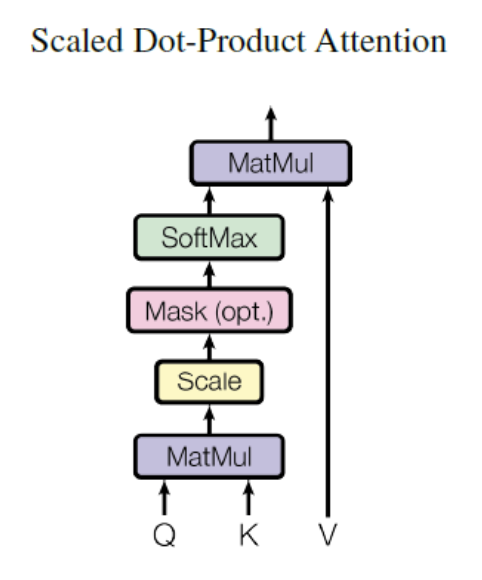

In [5]:
Image('/Users/jody/Downloads/Image/스크린샷 2022-02-26 오전 3.52.45.png')

In [6]:
def scaled_dot_product_attention(query, key, value, masked = False):
    key_dim_size = float(key.get_shape().as_list()[-1])
    key = tf.transpose(key, perm = [0,2,1])
    
    outputs = tf.matmul(query, key) / tf.sqrt(key_dim_size)
    
    if masked:
        diag_vals = tf.ones_like(outputs[0,:,:])
        tril = tf.linalg.LinearOperatorBlockLowerTriangular(diag_vals).to_dense()
        masks = tf.tile(tf.expand_dims(tirl, 0), [tf.shape(outputs)[0], 1, 1])
        paddings = tf.ones_like(masks) * (-2**30)
        outputs = tf.where(tf.equal(masks, 0), paddings, outputs)
    
    attention_map = tf.nn.softmax(outputs)
    return tf.matmul(attention_map, value)

### multi-head attention

- query, key, value에 해당하는 값을 받고, 해당 값에 해당하는 행렬 생성
- 생성된 행렬들을 heads에 해당하는 수만큼 분리
- 분리한 행렬들에 대해 각각 attention 수행
- 각 attention 결과들을 연결해 최종 attention 결과 생성

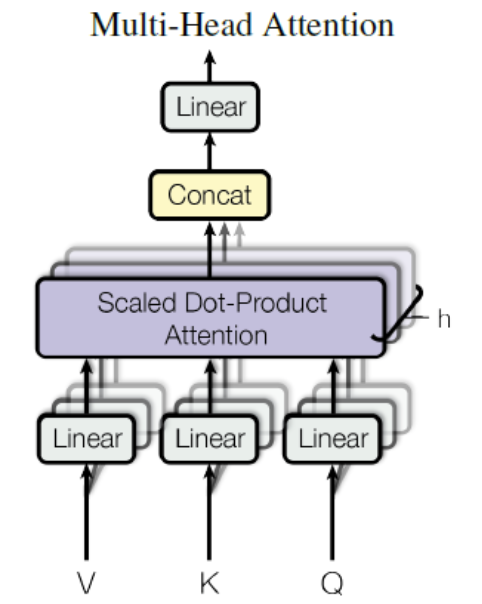

In [7]:
Image('/Users/jody/Downloads/Image/스크린샷 2022-02-26 오전 3.53.38.png')

In [8]:
def multi_head_attention(query, key, value, num_units, heads, masked = False):
    query = tf.keras.layers.Dense(num_units, activation = tf.nn.relu)(query)
    key = tf.keras.layers.Dense(num_units, activation = tf.nn.relu)(key)
    value = tf.keras.layers.Dense(num_units, activation = tf.nn.relu)(value)
    
    query = tf.concat(tf.split(query, heads, axis = -1), axis = 0)
    key = tf.concat(tf.split(key, heads, axis = -1), axis = 0)
    value = tf.concat(tf.split(value, heads, axis = -1), axis = 0)
    
    attention_map = scaled_dot_product_attention(query, key, value, masked)
    attn_outputs = tf.concat(tf.split(attention_map, heads, axis = 0), axis = -1)
    attn_outputs = tf.keras.layers.Dense(num_units, activation = tf.nn.relu)(attn_outputs)
    
    return attn_outputs

###  Position-wise Feed-Forward Networks

- multi-head attention의 결과인 행렬을 입력받아 연산
- 일반적인 완전 연결 신경망(Dense layer)를 사용
- position-wise FFNN은 인코더와 디코더에 모두 존재

In [9]:
def feed_forward(inputs, num_units):
    feature_shape = inputs.get_shape()[-1]
    inner_shape = tf.keras.layers.Dense(num_units, activation = tf.nn.relu)(inputs)
    outputs = tf.keras.layers.Dense(feature_shape)(inner_layer)
    return outputs

### Encoder

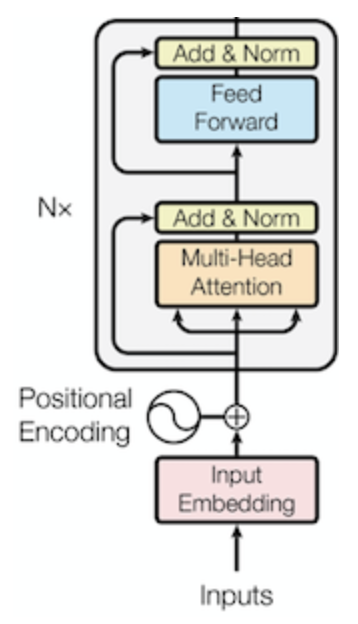

In [10]:
Image('/Users/jody/Downloads/Image/스크린샷 2022-02-26 오전 4.31.32.png')

In [11]:
def encoder_module(inputs, model_dim, ffn_dim, heads):
    self_attn = sublayers_connection(inputs, multi_head_attention(inputs, inputs, inputs, model_dim, heads))
    outputs = sublayer_connection(self_attn, feed_forward(self_attn, ffn_dim))
    return outputs

def encoder(inputs, model_dim, ffn_dim, heads, num_layers):
    outputs = inputs
    for i in range(num_layers):
        outputs = encoder_module(outputs, model_dim, ffn_dim, heads)
        
    return outputs

### Decoder

- masked decoder self-attention
- encoder-decoder attention
- position-wise FFNN

#### masked decoder self-attention

- decoder에서는 encoder와 달리 순차적으로 결과를 만들어 내야하기 때문에 다른 attention 방법을 사용함
- decoder 예측 시점 이후의 위치에 attention을 가할 수 없도록 masking 처리
- 결국 예측시점에서 예측은 알고 있는 위치까지만의 결과에 의존

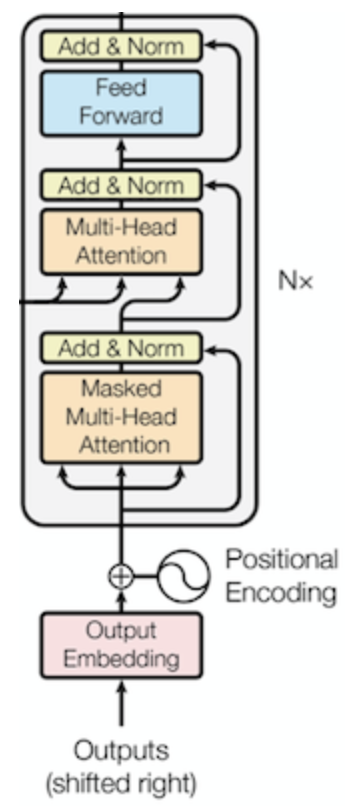

In [12]:
Image('/Users/jody/Downloads/Image/스크린샷 2022-02-26 오전 5.08.52.png')

In [13]:
def decoder_module(inputs, encoder_outputs, model_dim, ffn_dim, heads):
    masked_self_attn = sublayer_connection(inputs,
                                          multi_head_attention(inputs, inputs, inputs,
                                                              model_dim, heads, masked = True))
    self_attn = sublayer_connection(masked_self_attn,
                                   multi_head_attention(masked_self_attn,
                                                       encoder_outputs, # Query
                                                       encoder_outputs, # Key
                                                       model_dim, heads))
    outputs = sublayer_connection(self_attn, feed_forward(self_attn, ffn_dim))
    return outputs

def decoder(inputs, encoder_outputs, model_dim, ffn_dim,heads, num_layers):
    outputs = inputs
    for i in range(num_layers):
        outputs = decoder_module(outputs, encoder_outputs, model_dim, ffn_dim, heads)
        
    return outputs

## Chatbots

In [14]:
import re
import tensorflow as tf

filters = "([~.,!?\"';:])(])"
PAD = '<PADDING>'
STD = '<START>'
END = '<END>'
UNK = '<UNKNOWN>'

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FITER = re.compile(filters)

### Load Data

In [15]:
from sklearn.model_selection import train_test_split

def load_data(data_path):
    data_df = pd.read_csv(data_path, header = 0)
    question, answer = list(data_df['Q']),list(data_df['A'])
    train_input, eval_input, train_label, eval_label = train_test_split(question, answer,
                                                                       test_size = 0.33, random_state = 111)
    return train_input, train_label, eval_input, eval_label

### Vocab dict

In [16]:
def load_vocabulary(data_path):
    data_df = pd.read_csv(data_path, encoding = 'utf-8')
    question, answer = list(data_df['Q']),list(data_df['A'])
    if tokenize_as_morph: # 형태소 분석
        question = prepro_like_morphlized(question)
        answer = prepro_like_morphlized(answer)
    data = []
    data.extend(question)
    data.extend(answer)
    words = data_tokenizer(data)
    words = list(set(words))
    words[:0] = MARKER
    
    char2idx = {char:idx for idx, char in enumerate(words)}
    idx2char = {idx:char for idx, char in enumerate(words)}
    return char2idx, idx2char, len(char2idx)

### prepro_like_morphlized

In [17]:
from konlpy.tag import Okt

def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in data:
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', ''))) # 공백을 없애준 상태로
        result_data.append(morphlized_seq)
    return result_data

### Words Split

In [18]:
def data_tokenizer(data):
    words = []
    for sentence in data:
        sentence = re.sub(CHANGE_FITER, "", sentence)
        for word in sentence.split():
            words.append(word)
    return [word for word in words if word]

### Encoder Input

In [19]:
def enc_processing(value, dictionary):
    sequences_input_index = []
    sequences_length = []
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
        
    for sequence in value:
        sequence = re.sub(CHANGE_FITER, "", sequence) # 특수문자 제거
        sequence_index = []
        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])
        if len(sequence_index) > max_len:
            sequence_index = sequence_index[:maxlen] # 최대 길이를 넘어가지 않지 않게 잘라준다
        sequences_length.append(len(sequence_index)) # 길이값 저장
        sequence_index += (max_len - len(sequence_index)) * [dictionary[PAD]]
        ## max_len보다 작으면 그 자리를 PADDING
        sequences_input_index.append(sequence_index)
    return np.asarray(sequences_input_index), sequences_length

### Decoder Output

In [20]:
def dec_output_processing(value, dictionary):
    sequences_output_index = []
    sequences_length = []
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
        
    for sequence in value:
        sequence = re.sub(CHANGE_FITER, "", sequence) # 특수문자 제거
        sequence_index = []
        sequence_index = [dictionary[STD]] + [dictionary[word] for word in sequence.split()]
        
        if len(sequence_index) > max_len:
            sequence_index = sequence_index[:max_len] # 최대 길이를 넘어가지 않지 않게 잘라준다
        sequences_length.append(len(sequence_index)) # 길이값 저장
        sequence_index += (max_len -len(sequence_index)) * [dictionary[PAD]] 
        ## max_len보다 작으면 그 자리를 PADDING
        sequences_output_index.append(sequence_index)
    return np.asarray(sequences_output_index), sequences_length

### Decoder Target

In [21]:
def dec_target_processing(value, dictionary):
    sequences_target_index = []
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
        
    for sequence in value:
        sequence = re.sub(CHANGE_FITER, "", sequence) # 특수문자 제거
        sequence_index = [dictionary[word] for word in sequence.split()]
        
        if len(sequence_index) >= max_len:
            sequence_index = sequence_index[:max_len - 1] + [dictionary[END]] # 넘으면 잘라서 END
        else:
            sequence_index += [dictionary[END]]

        sequence_index += (max_len -len(sequence_index)) * [dictionary[PAD]] 
        ## max_len보다 작으면 그 자리를 PADDING
        sequences_target_index.append(sequence_index)
    return np.asarray(sequences_target_index)

### train input, eval input, rearrange

In [22]:
def train_input_fn(train_input_enc, train_output_enc, train_target_dec, batch_size):
    dataset = tf.compat.v1.data.Dataset.from_tensor_slices((train_input_enc, train_output_enc, train_target_dec))
    dataset = dataset.shuffle(buffer_size= len(train_input_enc))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(rearrange)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn(eval_input_enc, eval_output_enc, eval_target_dec, batch_size):
    dataset = tf.compat.v1.data.Dataset.from_tensor_slices((eval_input_enc, eval_output_enc, eval_target_dec))
    dataset = dataset.shuffle(buffer_size= len(eval_input_enc))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(rearrange)
    dataset = dataset.repeat(1)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def rearrange(input, output, target):
    features = {'input' : input, 'output' : output}
    return features, target

### Return to string

In [23]:
def pred2string(value, dictionary):
    sentence_string = []
    is_finished = False
    
    for v in value:
        sentence_string = [dictionary[index] for index in v['indexs']] # dict에 해당하는 값으로 바꿔줌
    answer = ""
    for word in sentence_string:
        if word == END:
            is_finished = True
            break
        
        if word != PAD and word != END:
            answer += word
            answer += " "
    return answer, is_finished

### Read Data

In [24]:
import pandas as pd

tokenize_as_morph = True

data_path = 'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'

char2idx, idx2char, len_vocab = load_vocabulary(data_path)
train_input, train_label, eval_input, eval_label = load_data(data_path)

### Modeling

In [25]:
def model(features, labels, mode, params):
    
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT
    
    position_encode = positional_encoding(params['embedding_size'], params['max_len'])
    if params['xavier_initializer']:
        embedding_initializer = 'glorot_normal'
    else:
        embedding_initializer = 'uniform'
    embedding = tf.keras.layers.Embedding(params['len_vocab'],
                                         params['embedding_size'],
                                         embedding_initializer=embedding_initializer)
    x_embedded_matrix = embedding(features['input']) + position_encode
    y_embedded_matrix = embedding(features['output']) + position_encode
    
    encoder_outputs = encoder(x_embedded_matrix, params['model_hidden_size'], params['ffn_hidden_size'],
                             params['attention_head_size'], params['layer_size'])
    decoder_outputs = decoder(y_embedded_matrix, params['model_hidden_size'], params['ffn_hidden_size'],
                             params['attention_head_size'], params['layer_size'])
    
    logits = tf.keras.layers.Dense(params['len_vocab'])(decoder_outputs)
    
    predict = tf.argmax(logits, 2)
    
    if PREDICT:
        predictions = {'index': predict,
                      'logits': logits}
        
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    labels_ = tf.one_hot(labels, params['len_vocab'])
    loss = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels_))
    accuracy = tf.compat.v1.metrics.accuracy(labels = labels, predictions = predict)
    
    metrics = {'accuracy':accuracy}
    tf.summary.scalar('accuracy', accuracy[1])
    
    if EVAL:
        return tf.estimator.EstimatorSpec(mode, losss = loss , eval_metric_ops = metrics)
    assert TRAIN
    
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=tf.compat.v1.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss = loss, train_op=train_op)

### Training

In [26]:
# Parameters
max_len = 25
epoch = 5000
batch_size = 256
embedding_size = 100
model_hidden_size = 100
ffn_hidden_size = 100
attention_head_size = 100
lr = 0.001
layer_size = 3
xavier_initializer = True

In [27]:
train_input_enc, train_input_enc_length = enc_processing(train_input, char2idx)
train_output_dec, train_output_dec_length = dec_output_processing(train_label, char2idx)
train_target_dec = dec_target_processing(train_label, char2idx)

eval_input_enc, eval_input_enc_length = enc_processing(eval_input, char2idx)
eval_output_dec, eval_output_dec_length = dec_output_processing(eval_label, char2idx)
eval_target_dec = dec_target_processing(eval_label, char2idx)

### Transfomer

In [28]:
transformer = tf.estimator.Estimator(model_fn = model,
                                   params = {'embedding_size' : embedding_size,
                                            'model_hidden_size' : model_hidden_size,
                                            'ffn_hidden_size' : ffn_hidden_size,
                                            'attention_head_size' : attention_head_size,
                                            'learning_rate' : lr,
                                            'len_vocab' : len_vocab,
                                            'layer_size' : layer_size,
                                            'max_len' : max_len,
                                            'xaiver_initializer' : xavier_initializer})

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xb/jj9xzp2d6v37h6nvn74k10p00000gn/T/tmpvc4foc1s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
transformer.train(input_fn = lambda : train_input_fn(train_input_enc, train_output_dec, train_target_dec, batch_size), steps= epoch)
eval_result = transformer.evaluate(input_fn =  lambda : eval_input_fn(eval_input_enc, eval_output_dec, eval_target_dec, batch_size))
print(**eval_result)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
INFO:tensorflow:Calling model_fn.


KeyError: 'xavier_initializer'

### Prediction

In [ ]:
def chatbot(question):
    pred_input_enc, pred_input_enc_length = enc_processing([question], char2idx)
    pred_output_dec, pred_output_dec_length = dec_output_processing([""], char2idx)
    pred_target_dec = dec_target_processing([""], char2idx)
    
    for i in range(max_len):
        if i > 0:
            pred_output_dec, pred_output_dec_length = dec_output_processing([answer], char2idx)
            pred_target_dec = dec_target_processing([answer], char2idx)
        predictions = transformer.predict(input_fn =  lambda : eval_input_fn(pred_input_enc_length, pred_output_dec_length, pred_target_dec, batch_size = 1))
        
        answer, finished = pred2string(predictions, idx2char)
        
        if finished:
            break
        
        
        return answer

In [ ]:
chatbot('안녕?')

In [ ]:
chatbot('너 누구냐?')